<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C3/W4/ungraded_labs/C3_W4_Lab_2_irish_lyrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Generating Text from Irish Lyrics

In the previous lab, you trained a model on just a single song. You might have found that the output text can quickly become gibberish or repetitive. Even if you tweak the hyperparameters, the model will still be limited by its vocabulary of only 263 words. The model will be more flexible if you train it on a much larger corpus and that's what you'll be doing in this lab. You will use lyrics from more Irish songs then see how the generated text looks like. You will also see how this impacts the process from data preparation to model training. Let's get started!

## Imports

In [ ]:
import tensorflow as tf
import numpy as np 

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## Building the Word Vocabulary

You will first download the lyrics dataset. These will be from a compilation of traditional Irish songs and you can see them [here](https://github.com/https-deeplearning-ai/tensorflow-1-public/blob/main/C3/W4/misc/Laurences_generated_poetry.txt). 

In [ ]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course3/irish-lyrics-eof.txt

Next, you will lowercase and split the plain text into a list of sentences:

In [ ]:
# Load the dataset
data = open('./irish-lyrics-eof.txt').read()

# Lowercase and split the text
corpus = data.lower().split("\n")

# Preview the result
print(corpus)

In [ ]:
# ['come all ye maidens young and fair', 'and you that are blooming in your prime', 'always beware and keep your garden fair', 'let no man steal away your thyme', ' ' ]

From here, you can initialize the `Tokenizer` class and generate the word index dictionary:

In [ ]:
# Initialize the Tokenizer class
tokenizer = Tokenizer()

# Generate the word index dictionary
tokenizer.fit_on_texts(corpus)

# Define the total words. You add 1 for the index `0` which is just the padding token.
total_words = len(tokenizer.word_index) + 1

print(f'word index dictionary: {tokenizer.word_index}')
print(f'total words: {total_words}')


# word index dictionary: {'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'of': 6, 'my': 7, 'in': 8, 'me': 9, 'for': 10, 'you': 11, 'all': 12,
# total words: 2690


## Preprocessing the Dataset

Next, you will generate the inputs and labels for your model. The process will be identical to the previous lab. The `xs` or inputs to the model will be padded sequences, while the `ys` or labels are one-hot encoded arrays.

In [ ]:
# Initialize the sequences list
input_sequences = []

# Loop over every line
for line in corpus:

	# Tokenize the current line
	token_list = tokenizer.texts_to_sequences([line])[0]

	# Loop over the line several times to generate the subphrases
	for i in range(1, len(token_list)):
		
		# Generate the subphrase
		n_gram_sequence = token_list[:i+1]

		# Append the subphrase to the sequences list
		input_sequences.append(n_gram_sequence)

# Get the length of the longest line
max_sequence_len = max([len(x) for x in input_sequences])

# Pad all sequences
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Create inputs and label by splitting the last token in the subphrases
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

# Convert the label into one-hot arrays
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

You can then print some of the examples as a sanity check.

In [ ]:
# Get sample sentence
sentence = corpus[0].split()
print(f'sample sentence: {sentence}')

# Initialize token list
token_list = []

# Look up the indices of each word and append to the list
for word in sentence: 
  token_list.append(tokenizer.word_index[word])

# Print the token list
print(token_list)


# sample sentence: ['come', 'all', 'ye', 'maidens', 'young', 'and', 'fair']
# [51, 12, 96, 1217, 48, 2, 69]

In [ ]:
# Pick element
elem_number = 5

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {tokenizer.sequences_to_texts([xs[elem_number]])}')

# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

# token list: [   0    0    0    0    0    0    0    0    0   51   12   96 1217   48  2]
# decoded to text: ['come all ye maidens young and']
# one-hot label: [0. 0. 0. ... 0. 0. 0.]
# index of label: 69  다음에 올 단어의 인덱스

In [ ]:
# Pick element
elem_number = 4

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {tokenizer.sequences_to_texts([xs[elem_number]])}')

# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')


# token list: [   0    0    0    0    0    0    0    0    0    0   51   12   96 1217
#    48]
# decoded to text: ['come all ye maidens young']
# one-hot label: [0. 0. 1. ... 0. 0. 0.]
# index of label: 2

## Build and compile the Model

Next, you will build and compile the model. We placed some of the hyperparameters at the top of the code cell so you can easily tweak it later if you want.

In [ ]:
# Hyperparameters
embedding_dim = 100
lstm_units = 150
learning_rate = 0.01

# Build the model
model = Sequential([
          Embedding(total_words, embedding_dim, input_length=max_sequence_len-1),
          Bidirectional(LSTM(lstm_units)),
          Dense(total_words, activation='softmax')
])

# Use categorical crossentropy because this is a multi-class problem
model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )

# Print the model summary
model.summary()

## Train the model

From the model summary above, you'll notice that the number of trainable params is much larger than the one in the previous lab. Consequently, that usually means a slower training time. It will take roughly 7 seconds per epoch with the GPU enabled in Colab and you'll reach around 76% accuracy after 100 epochs.

In [ ]:
epochs = 100

# Train the model
history = model.fit(xs, ys, epochs=epochs)

Epoch 100/100
377/377 [==============================] - 3s 8ms/step - loss: 0.8050 - accuracy: 0.7841

You can visualize the accuracy below to see how it fluctuates as the training progresses.

In [ ]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')

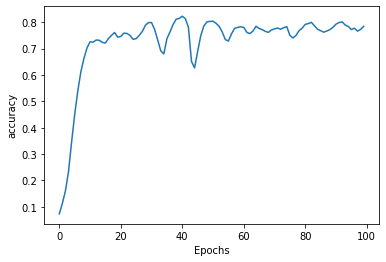

## Generating Text

Now you can let the model make its own songs or poetry! Because it is trained on a much larger corpus, the results below should contain less repetitions as before. The code below picks the next word based on the highest probability output.

In [ ]:
# Define seed text
seed_text = "help me obi-wan kinobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
	token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	
	# Feed to the model and get the probabilities for each index
	probabilities = model.predict(token_list)

	# Get the index with the highest probability
	predicted = np.argmax(probabilities, axis=-1)[0]

	# Ignore if index is 0 because that is just the padding.
	if predicted != 0:
		
		# Look up the word associated with the index. 
		output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
		seed_text += " " + output_word

# Print the result	
print(seed_text)

help me obi-wan kinobi youre my only hope said have heard the town of athy more i love sinking funds to sinking strangely alone that i love i love twill i gone and i keep gone i couldnt shoot gone i couldnt shoot the sinking funds when gone more sinking note when love i love gone i gone love again he rocky when volunteers sinking eyes gone i love i love i back back against the rocky road to sea twilight rebel love sinking eyes i love i right i love i love best i right to darlin name back right darlin saw i love again ache pair


Here again is the code that gets the top 3 predictions and picks one at random.

In [ ]:
# Define seed text
seed_text = "help me obi-wan kinobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
  token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	
	# Feed to the model and get the probabilities for each index
  probabilities = model.predict(token_list)

  # Pick a random number from [1,2,3]
  choice = np.random.choice([1,2,3])
	
  # Sort the probabilities in ascending order 
  # and get the random choice from the end of the array
  predicted = np.argsort(probabilities)[0][-choice]

	# Ignore if index is 0 because that is just the padding.
  if predicted != 0:
		
		# Look up the word associated with the index. 
	  output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
	  seed_text += " " + output_word

# Print the result	
print(seed_text)

help me obi-wan kinobi youre my only hope in my true are they were eyes glisten love i right love paddy of sinking carried saw love them redeem gone i gone again hat i right forth when run gone i couldnt new gone eyes love best love than i a sinking asunder when i i thinking gone as hat i sat rink rink love easy gone by seen came love to sea breeze love me though love and i drew laughs i vermin i variety gone love again fulfill stranger sinking right in i ever should make bantry pearse sinking bride love i lovd i remember i walked


## Wrap Up

This lab shows the effect of having a larger dataset to train your text generation model. As expected, this will take a longer time to prepare and train but the output will less likely become repetitive or gibberish. Try to tweak the hyperparameters and see if you get better results. You can also find some other text datasets and use it to train the model here.  